In [260]:
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL, cv2
import warnings
warnings.filterwarnings("ignore")
from torchvision.ops import box_iou
import time
import os
from itertools import repeat
import multiprocessing as mp
import matplotlib.pyplot as plt 
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../scripts/')
from resized_anchor_boxes import resize_anchor_boxes

%load_ext autoreload
%autoreload 2


In [184]:
files = np.loadtxt('../../bird_dataset/CUB_200_2011/images.txt', dtype=str, delimiter=' ', usecols=(1,))
bboxes = np.loadtxt('../../bird_dataset/CUB_200_2011/bounding_boxes.txt', dtype=int, delimiter=' ', usecols=(1,2,3,4))

In [6]:
img = PIL.Image.open('../../bird_dataset/CUB_200_2011/images/' + files[0])

In [8]:
img_ = cv2.rectangle(np.array(img), (bboxes[0][0], bboxes[0][1]), (bboxes[0][0]+bboxes[0][2], bboxes[0][1]+bboxes[0][3]), (0,255,0), 2)

In [14]:
bboxes[0]

array([ 60,  27, 325, 304])

In [15]:
bboxes[1]

array([139,  30, 153, 264])

In [186]:
bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]

In [46]:
img = PIL.Image.open('../../bird_dataset/CUB_200_2011/images/' + files[1])
img = cv2.rectangle(np.array(img), ((bboxes[1][0]), (bboxes[1][1])), (bboxes[1][2], bboxes[1][3]), (0,255,0), 2)

In [101]:
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x3, y3, x4, y4 = box2

    x_max = torch.max(x1, x3)
    y_max = torch.max(y1, y3)
    x_min = torch.min(x2, x4)
    y_min = torch.min(y2, y4)

    intersection = torch.max(torch.Tensor([0]), x_min - x_max) * torch.max(torch.Tensor([0]), y_min - y_max)
    union = (x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - intersection

    return intersection / union

In [132]:
def get_iou(clusters, boxes):
    final_preds = torch.zeros((len(boxes), len(clusters)))
    # assert type(box1) == type(box2) == torch.Tensor, 'Please give torch tensor only'

    for c in range(len(clusters)):
        final_preds[:, c] = calculate_iou(boxes, clusters[c])
    
    # final_preds = torch.argmax(final_preds, dim=1)
    
    return final_preds

* If there are 3 clusters
* box : [3 values inside here which belongs to each cluster]

In [109]:
get_iou(torch.Tensor(bboxes[:3]), torch.Tensor(bboxes[:10]))

In [226]:
# rows, distances, last_clusters

def find_anchors(bboxes, k, stop_iter):
    rows = bboxes.shape[0]
    distances = torch.empty((rows, k))
    last_clusters = torch.zeros((rows,))

    cluster_index = np.random.choice(rows, k, replace=False)

    clusters = bboxes[cluster_index].clone()
    itereation = 0
    while True:
        itereation += 1
        distances = get_iou(clusters, bboxes)
        nearest_clusters = torch.argmax(distances, dim=1)
        if torch.equal(last_clusters, nearest_clusters):
            itereation += 1
            if itereation > stop_iter:
                break
        else:
            itereation = 0
        for cluster in range(k):
            clusters[cluster] = torch.mean(bboxes[nearest_clusters == cluster], dim=0)
        last_clusters = nearest_clusters.clone()
    return clusters, distances


In [200]:
# clusts, distances = find_anchors(torch.Tensor(bboxes).float(), 2, 5)

In [218]:
temp = []
for x in files:
    temp.append('../../bird_dataset/CUB_200_2011/images/' + x)

In [261]:
resize_anchor_boxes(temp, bboxes)

[[30.72, 20.632835820895522, 197.12, 252.94328358208955],
 [71.168, 22.857142857142858, 149.504, 224.0],
 [7.168, 82.62824207492795, 205.824, 219.850144092219],
 [69.08915662650602, 46.08, 226.39036144578313, 169.984],
 [54.13897280966767, 33.68421052631579, 157.7764350453172, 237.81052631578947],
 [16.896, 28.868085106382978, 145.408, 244.01702127659576],
 [3.584, 56.470588235294116, 218.624, 253.74117647058824],
 [39.936, 56.30690537084399, 210.432, 159.7544757033248],
 [57.344, 46.76923076923077, 170.496, 163.07692307692307],
 [27.648, 4.923076923076923, 231.424, 252.30769230769232],
 [0.7314285714285714, 38.034285714285716, 250.88, 228.2057142857143],
 [28.64761904761905, 19.2, 137.75238095238095, 246.85714285714286],
 [30.019543973941367, 16.384, 194.29315960912052, 250.368],
 [27.062857142857144, 29.257142857142856, 218.69714285714286, 163.84],
 [11.776, 54.03693931398417, 214.016, 214.12137203166228],
 [72.192, 62.38655462184874, 203.264, 213.6918767507003],
 [29.257142857142856

In [185]:
def process(data):
    img_path, box, target_image_size = data
    assert os.path.exists(img_path == True), 'Image path issue.'
    x1, y1, x2, y2 = box
    img = cv2.imread(img_path)
    height, width = img.shape[0], img.shape[1]
    target_height, target_width = target_image_size
    x1_scale = x1 / width
    y1_scale = y1 / height
    x2_scale = x2 / width
    y2_scale = y2 / height
    x1_update = x1_scale * target_width
    y1_update = y1_scale * target_height
    x2_update = x2_scale * target_width
    y2_update = y2_scale * target_height
    return [x1_update, y1_update, x2_update, y2_update]

In [220]:
with mp.Pool(6) as p:
    returns = list(p.map(process, list(zip(temp, bboxes, repeat((256, 256))))))

In [223]:
updated_boxes = torch.Tensor(returns)

In [238]:
clusts, distances = find_anchors(updated_boxes, 3, 5)

In [245]:
torch.argmax(distances, dim=1)

tensor([1, 2, 1,  ..., 0, 1, 2])

100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


Text(0, 0.5, 'IoU score')

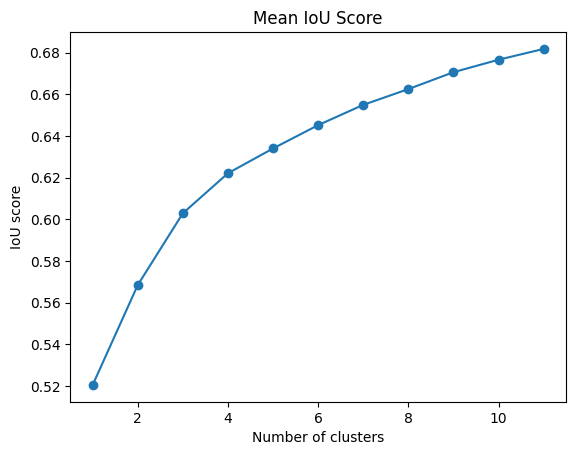

In [257]:
cluster_list = [x for x in range(1, 12)]
mean_distances, anchor_boxes = [], []
for k in tqdm(cluster_list):
    anchors, dists = find_anchors(updated_boxes, k, 5)
    indxs = torch.argmax(dists, dim=1)
    filtered_distances = []
    for i, distance in enumerate(dists):
        filtered_distances.append(distance[indxs[i]].item())
    mean_distances.append(np.mean(filtered_distances))
    anchor_boxes.append(anchors)    
plt.plot(cluster_list, mean_distances)
plt.scatter(cluster_list, mean_distances)
plt.title("Mean IoU Score")
plt.xlabel("Number of clusters")
plt.ylabel("IoU score")

In [259]:
anchor_boxes[3]

tensor([[ 37.8929,  40.9718, 217.7340, 221.9222],
        [ 80.6492,  67.7948, 172.2884, 193.3782],
        [ 36.7458,  64.7449, 155.4134, 202.4809],
        [ 97.3244,  67.5725, 219.2982, 203.4283]])